In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input,MultiHeadAttention, InputLayer, LSTM, Dense, GRU, Conv1D, MaxPooling1D, Flatten, Bidirectional, TimeDistributed, Dropout, LeakyReLU, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW, Adam

from shared import read_dataset, plot_results, evaluate_price_predictions, mean_abs_error

2023-12-07 17:07:01.690689: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-07 17:07:01.717020: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 17:07:01.717063: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 17:07:01.717085: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 17:07:01.722338: I tensorflow/core/platform/cpu_feature_g

#Trading Days: (3019, 24)


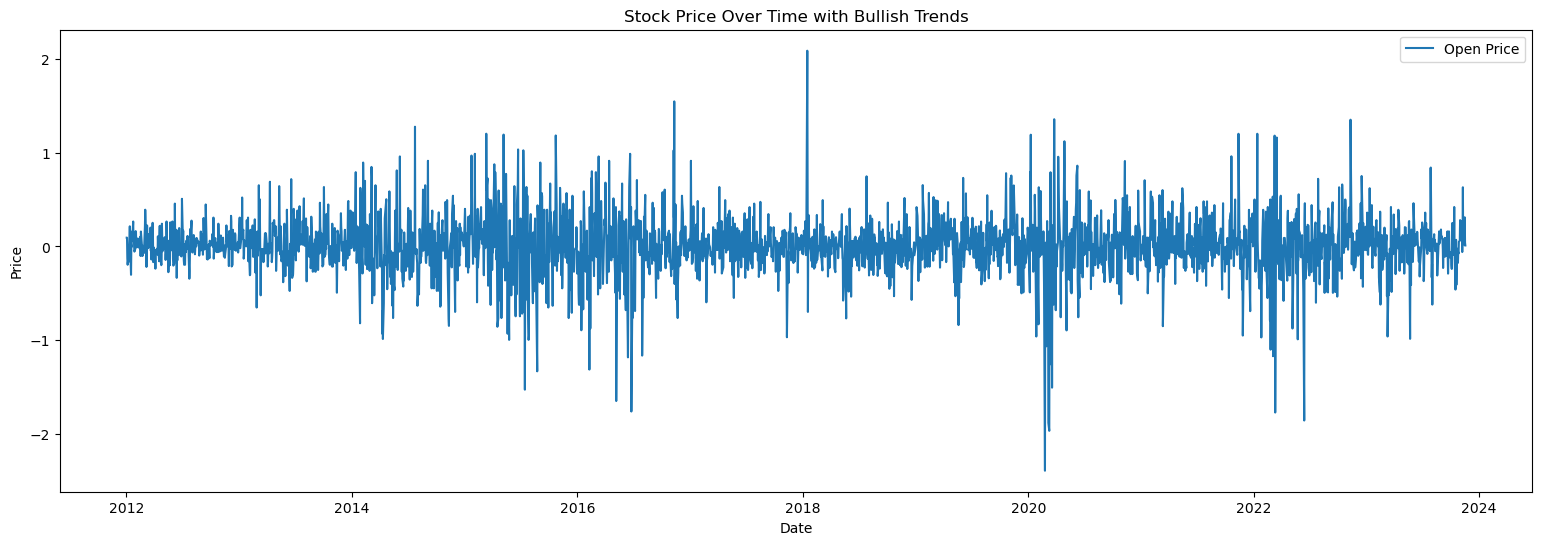

['High Diff', 'Open', 'High', 'Low', 'Close', 'Volume', 'ma7', 'ma7_diff', 'ma21', 'ma21_diff', '26ema', '26ema_diff', '12ema', '12ema_diff', 'MACD', 'upper_band', 'lower_band', 'momentum', 'fourier_short', 'fourier_medium', 'fourier_long', 'Volatility_21', 'Close Diff', 'Open Diff']


In [2]:
start = "2012-01-01"
end = "2023-12-01"
target_column_name = 'High Diff'
path = '../models/lstm_model/predictor_adj_close.h5'

AZM = read_dataset('../data/AZM.MI_ta.csv', start, end)

data = AZM
data.dropna(inplace=True)

cols = [target_column_name] + [ col for col in data if col != target_column_name]
target_column = list(data.columns).index(target_column_name)
data = data[cols]

print(f"#Trading Days: {data.shape}")

plt.figure(figsize=(19, 6))
plt.plot(data[target_column_name], label='Open Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Over Time with Bullish Trends')
plt.legend()
plt.show()
print(cols)

In [3]:
data.shape

(3019, 24)

#Trading Days: (2731, 24)

In [4]:
SEQUENCE_LENGTH = 40
PREDICTION_SHIFT= 0
NUM_FEATURES = 24

# data = data.drop('Low Diff', axis=1)
# data = data.drop('Adj Close', axis=1)

# Define feature array and target array to train the model.
data_array = np.array(data.values)
target_array = np.array(data[target_column_name].values).reshape(-1, 1)

# Normalize the data
scaler_data = MinMaxScaler()
scaler_data.fit(data_array)
data_array = scaler_data.transform(data_array)

scaler_target = MinMaxScaler()
scaler_target.fit(target_array)
target_array = scaler_target.transform(target_array)

def create_sequences(data, target, seq_length):
    sequence_data = []
    sequence_target = []
    for i in range(seq_length, len(data)-PREDICTION_SHIFT):
        sequence_data.append(data[i-seq_length:i])
        sequence_target.append(target[i+PREDICTION_SHIFT])
    return np.array(sequence_data), np.array(sequence_target)

data_sequences, target_sequences = create_sequences(data_array, target_array, SEQUENCE_LENGTH)

# Split the data
train_size = int(data_sequences.shape[0]* 0.97)
evaluation_size = int(0) # no evaluation


train_data, validation_data, test_data = data_sequences[:train_size], data_sequences[train_size:train_size+evaluation_size], data_sequences[train_size+evaluation_size:]
train_target, validation_target, test_target = target_sequences[:train_size], target_sequences[train_size:train_size+evaluation_size], target_sequences[train_size+evaluation_size:]

train_data = train_data.reshape(train_data.shape[0], 1, SEQUENCE_LENGTH, NUM_FEATURES)
validation_data = validation_data.reshape(validation_data.shape[0], 1,SEQUENCE_LENGTH, NUM_FEATURES)
test_data = test_data.reshape(test_data.shape[0], 1, SEQUENCE_LENGTH, NUM_FEATURES)

print(f"Train | data: {train_data.shape} target: {train_target.shape}")
print(f"Valid | data: {validation_data.shape} target: {validation_target.shape}")
print(f"Testt | data: {test_data.shape} target: {test_target.shape}")


Train | data: (2889, 1, 40, 24) target: (2889, 1)
Valid | data: (0, 1, 40, 24) target: (0, 1)
Testt | data: (90, 1, 40, 24) target: (90, 1)


In [5]:
# TESTING CORRECTNESS OF GENERATED SEQUENCES
test_index = 0
test_column_prompt = 0
a = scaler_data.inverse_transform(data_sequences[test_index])
b = scaler_target.inverse_transform(target_sequences)

for i in range (0, SEQUENCE_LENGTH):
    print(f"A[{i}]: {a[i][test_column_prompt]}")

print(f'b: {b[test_index]}')

A[0]: 0.0930747985839842
A[1]: 0.09307384490966784
A[2]: -0.1256508827209474
A[3]: -0.19545698165893544
A[4]: -0.1628799438476561
A[5]: -0.16288089752197246
A[6]: 0.013960838317871213
A[7]: 0.09307527542114262
A[8]: 0.21407175064086925
A[9]: 0.037230014801025064
A[10]: -0.3024930953979493
A[11]: 0.01396131515502914
A[12]: -0.00465440750122078
A[13]: 0.15822744369506853
A[14]: 0.06980562210082984
A[15]: 0.26526308059692394
A[16]: 0.055845260620117056
A[17]: 0.14426565170288147
A[18]: 0.0
A[19]: -0.05584478378295963
A[20]: -0.023268222808837998
A[21]: 0.1628799438476561
A[22]: 0.14892005920410126
A[23]: 0.027922153472900352
A[24]: -0.00930690765380836
A[25]: 0.027921676635742923
A[26]: 0.08376836776733326
A[27]: -0.009308338165283137
A[28]: 0.009308338165283137
A[29]: -0.009308338165283137
A[30]: 0.037230014801025064
A[31]: -0.027921676635741927
A[32]: 0.10238170623779305
A[33]: -0.10238170623779305
A[34]: 0.1582269668579101
A[35]: 0.023267745971679573
A[36]: 0.013962268829345493
A[37]: 

In [36]:
input_shape=(train_data.shape[1], train_data.shape[2])

def early_stopping(patience):
    return EarlyStopping(
        monitor='val_loss',
        patience=patience,
        verbose=2,
        mode='min',
        restore_best_weights=True,
    )

def build_attention(seq_length, num_features):
    input_layer = Input(shape=(1, seq_length, num_features))
    flatten = TimeDistributed(Flatten()) (input_layer)
    
    attention_layer1 = MultiHeadAttention(
                            num_heads=1,
                            key_dim=1,
                            # dropout=0.4,
                            # kernel_regularizer=l2(0.001),
                            # bias_regularizer=l2(0.0001),
                            # activity_regularizer=l2(0.001)
                            )(flatten, flatten, flatten)
    attention_flat = Flatten()(attention_layer1)

    # lstm_layer = Bidirectional(LSTM(128, return_sequences=False)) (flatten)
    # lstm_reg = Dropout(0.4)(lstm_layer)
    # lstm_flat = Flatten()(lstm_reg)

    # concatenated = Concatenate()([attention_flat, lstm_flat])
    
    drop = Dropout(0.4)(attention_flat)

    attention_output = Dense(1)(attention_flat)

    return Model(input_layer, attention_output)

def train_attention_model(model, X_train, y_train):
    patience = 100
    epochs = 10000
    batch_size = 128 # 43 # 128

    model.compile(
        optimizer=Adam(),
        loss='mean_absolute_error',
    )
    model.fit(X_train, y_train,
                epochs = epochs,
                batch_size = batch_size,
                shuffle =True,
                validation_split=0.2,
                callbacks=[early_stopping(patience)]
            )

In [37]:
attention = build_attention(SEQUENCE_LENGTH, NUM_FEATURES)
# attention.summary()
train_attention_model(attention, train_data, train_target)

Epoch 1/10000
19/19 [==============================] - 1s 7ms/step - loss: 0.2358 - val_loss: 0.0626
Epoch 2/10000
19/19 [==============================] - 0s 3ms/step - loss: 0.0561 - val_loss: 0.0498
Epoch 3/10000
19/19 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0486
Epoch 4/10000
19/19 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0486
Epoch 5/10000
19/19 [==============================] - 0s 3ms/step - loss: 0.0477 - val_loss: 0.0484
Epoch 6/10000
19/19 [==============================] - 0s 3ms/step - loss: 0.0474 - val_loss: 0.0484
Epoch 7/10000
19/19 [==============================] - 0s 3ms/step - loss: 0.0475 - val_loss: 0.0483
Epoch 8/10000
19/19 [==============================] - 0s 3ms/step - loss: 0.0486 - val_loss: 0.0489
Epoch 9/10000
19/19 [==============================] - 0s 3ms/step - loss: 0.0479 - val_loss: 0.0485
Epoch 10/10000
19/19 [==============================] - 0s 3ms/step - loss: 0.0474 - val_lo

91/91 [==============================] - 0s 790us/step
Mean Absolute Error (MAE): 0.18
Mean Squared Error (MSE): 0.07
Root Mean Squared Error (RMSE): 0.27
Mean Absolute Percentage Error (MAPE): 1104.48%
R-squared (R²): -2.85


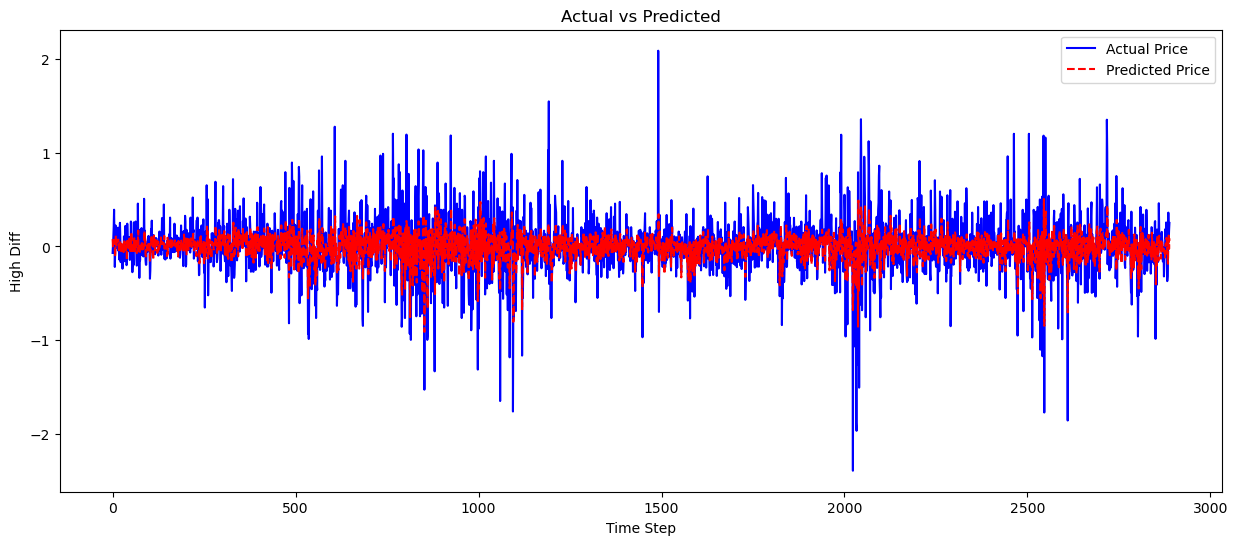

In [40]:
data_to_predict = train_data
actual_prediction = train_target

attention.evaluate(data_to_predict, actual_prediction)

# TESTing: DENORMALIZE TARGET AND PREDICTIONS ##
price_predicted_array = scaler_target.inverse_transform(attention.predict(data_to_predict).squeeze().reshape(-1, 1))
price_actual_array = scaler_target.inverse_transform(actual_prediction).flatten()


## Evaluation
evaluate_price_predictions(price_predicted_array.flatten(), price_actual_array.flatten())

# ## PLOTting #
plot_results(price_actual_array, price_predicted_array, target_column_name)

3/3 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 0.14
Mean Squared Error (MSE): 0.04
Root Mean Squared Error (RMSE): 0.20
Mean Absolute Percentage Error (MAPE): 553.85%
R-squared (R²): -6.02


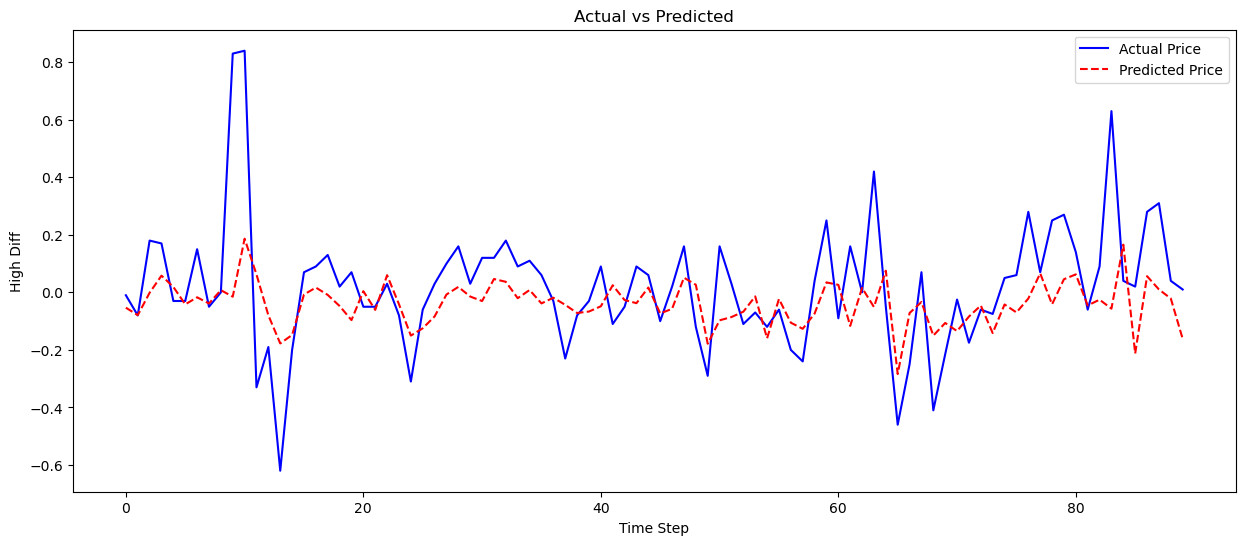

In [41]:
data_to_predict = test_data
actual_prediction = test_target

attention.evaluate(data_to_predict, actual_prediction)

# TESTing: DENORMALIZE TARGET AND PREDICTIONS ##
price_predicted_array = scaler_target.inverse_transform(attention.predict(data_to_predict).squeeze().reshape(-1, 1))
price_actual_array = scaler_target.inverse_transform(actual_prediction).flatten()

## Evaluation
evaluate_price_predictions(price_predicted_array.flatten(), price_actual_array.flatten())

## PLOTting #
plot_results(price_actual_array, price_predicted_array, target_column_name)

Mean Absolute Error (MAE): 0.12